# Model Based Machine Learning Project

We have chosen to work with a dataset on Life Expectancy collected by (WHO).

## Loadning and visualizing the data 

We start by importing packages.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib as mplib
from matplotlib import pyplot as plt
import seaborn as sns

import itertools
palette = itertools.cycle(sns.color_palette("tab20", n_colors=20))
import matplotlib.cm as cm

from sklearn import linear_model
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

import random

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)

C:\Users\Magnus\anaconda3\envs\pyro\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("archive/Data_processed_subregions.csv",delimiter=";")
LED = pd.DataFrame(data)

In [3]:
  def ParamHistPlot(MCMC_output,paraToPlot,y_max):
    
    numberOfNum = MCMC_output[paraToPlot].ndim
     
    if numberOfNum == 1:
        color = next(palette)
        sns.kdeplot(MCMC_output[paraToPlot])
        # Alternative
        sns.histplot(data=MCMC_output[paraToPlot], kde=True, stat='density', color=color, element="step")

        legend_title = "%s" % (paraToPlot)
        x_coord = MCMC_output[paraToPlot].mean()
        y_coord = plt.gca().get_ylim()[1] - (0.05 * plt.gca().get_ylim()[1])
        plt.annotate(legend_title, xy=(x_coord, y_coord), xycoords='data',
                     xytext=(10, 0), textcoords='offset points',color=color)

    else:
        loopCounter = MCMC_output[paraToPlot].size(1)
        
        for i in range(loopCounter):
            color = next(palette)
            sns.kdeplot(MCMC_output[paraToPlot][:,i])
            # Alternative
            sns.histplot(data=MCMC_output[paraToPlot][:,i], kde=True, stat='density', color=color, element="step")

            legend_title = "%s%d" % (paraToPlot,i)
            x_coord = MCMC_output[paraToPlot][:, i].mean()
            y_coord = plt.gca().get_ylim()[1] - (i * 0.05 * plt.gca().get_ylim()[1])
            plt.annotate(legend_title, xy=(x_coord, y_coord), xycoords='data',
                         xytext=(10, 0), textcoords='offset points',color=color)
    
    plt.axis([MCMC_output[paraToPlot].min(),MCMC_output[paraToPlot].max(),0,y_max])
    #plt.axis([-0.5,0.5,0,y_max])
    plt.show()

In [4]:
print(LED['continent'].unique()) #Check grouping
print(LED['subregion'].unique())

['Asia' 'Europe' 'Africa' 'North America' 'South America' 'Oceania']
['Southern Asia' 'Southern Europe' 'Northern Africa' 'Sub-Saharan Africa'
 'Latin America and the Caribbean' 'Western Asia'
 'Australia and New Zealand' 'Western Europe' 'Eastern Europe'
 'South-eastern Asia' 'Northern America' 'Eastern Asia' 'Northern Europe'
 'Melanesia' 'Central Asia' 'Micronesia' 'Polynesia']


In [5]:
print(LED.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                2936 non-null   object 
 1   continent              2936 non-null   object 
 2   subregion              2936 non-null   object 
 3   Life expectancy        2936 non-null   float64
 4   Year                   2936 non-null   int64  
 5   Status                 2936 non-null   int64  
 6   infant deaths          2936 non-null   float64
 7   Alcohol                2936 non-null   float64
 8   Hepatitis B            2936 non-null   float64
 9   MeaslesPrMillion       2936 non-null   float64
 10  OverweightOfAdults%    2936 non-null   float64
 11  Polio                  2936 non-null   int64  
 12  Total expenditure      2936 non-null   float64
 13  Diphtheria             2936 non-null   int64  
 14   HIV/AIDS              2936 non-null   float64
 15  GDP 

## Setting up data for Pyro model

In [6]:
LED.head(5)

,Country,continent,subregion,Life expectancy,Year,Status,infant deaths,Alcohol,Hepatitis B,MeaslesPrMillion,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,Schooling,WaterFacility,WomenInParlament
0,Afghanistan,Asia,Southern Asia,62.659,2015,0,53.0,0.00,64.0,7.051856,...,6,8.16,65,0.1,6.372055,17.334595,17.2,10.1,61.339781,27.710843
1,Afghanistan,Asia,Southern Asia,62.545,2014,0,55.0,0.01,62.0,6.200509,...,58,8.18,62,0.1,6.419501,17.303381,17.5,10.0,58.659374,27.710843
2,Afghanistan,Asia,Southern Asia,62.417,2013,0,57.2,0.01,64.0,6.066108,...,62,8.13,64,0.1,6.450067,17.266806,17.7,9.9,56.014043,27.710843
3,Afghanistan,Asia,Southern Asia,61.923,2012,0,59.4,0.01,67.0,7.933080,...,67,8.52,67,0.1,6.508708,17.232138,17.9,9.8,53.403517,27.710843
4,Afghanistan,Asia,Southern Asia,61.419,2011,0,61.8,0.01,68.0,8.011023,...,68,7.87,68,0.1,4.167242,17.191361,18.2,9.5,50.827846,27.710843


In [7]:
mat = LED.values

X = mat[:,6:].astype("float") #These are the regressors
print(X.shape)

y_original = mat[:,3].astype("float") #This is the target variable life expectancy
print(y_original.shape)

#These are the hierarchies
continent = mat[:,1] 
subregion = mat[:,2] 
developed = mat[:,5]
print(continent.shape)

(2936, 15)
(2936,)
(2936,)


In [8]:
#Setup split for traning, validation and test data set. We will use 2000-2012 as traning and 2013-2015 as test. 
#Remember to add in report: We can not split randomly as then we will feed info to the model I should not have. 
training_idx = (data['Year'] >= 2000) & (data['Year'] <= 2011)
test_idx = (data['Year'] >= 2012) & (data['Year'] <= 2013)
val_idx = (data['Year'] >= 2014) & (data['Year'] <= 2015)

In [11]:
# standardize input features
X_mean = X[training_idx,:].mean(axis=0)
X_std = X[training_idx,:].std(axis=0)
X = (X - X_mean) / X_std

# standardize target
y_mean = y_original[training_idx].mean()
y_std = y_original[training_idx].std()
y = (y_original - y_mean) / y_std

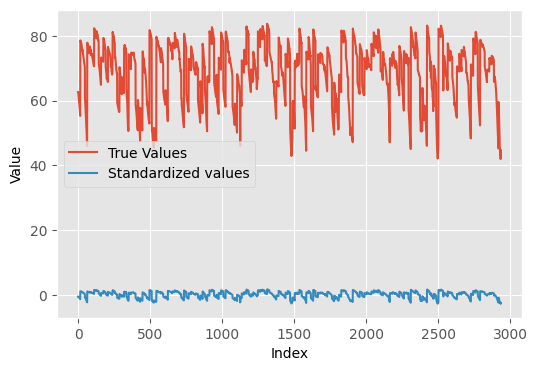

In [12]:
plt.plot(y_original, label='True Values')
plt.plot(y, label='Standardized values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [13]:
def dataSplit(data,trainIDX,testIDX,valIDX):
    train = data[trainIDX]
    test  = data[testIDX]
    val   = data[valIDX]
    
    return train, test, val

#Split features 
X_train = X[training_idx,:]
X_test = X[test_idx,:]
X_val = X[val_idx, :]

#Split observations
y_train, y_test, y_val = dataSplit(y,training_idx,test_idx,val_idx)

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))
print("num val: %d" % len(y_val))

developed_train, developed_test, developed_val = dataSplit(developed,training_idx,test_idx,val_idx)

num train: 2196
num test: 374
num val: 366


In [14]:
# Setting up hierarchical dictonaries 
continent_dict = {'Asia': 0, 'Europe': 1, 'Africa': 2, 'North America': 3,  'South America': 4, 'Oceania': 5}

subregion_dict = region_dict = {
    'Southern Asia': 0,
    'Southern Europe': 1,
    'Northern Africa': 2,
    'Sub-Saharan Africa': 3,
    'Latin America and the Caribbean': 4,
    'Western Asia': 5,
    'Australia and New Zealand': 6,
    'Western Europe': 7,
    'Eastern Europe': 8,
    'South-eastern Asia': 9,
    'Northern America': 10,
    'Eastern Asia': 11,
    'Northern Europe': 12,
    'Melanesia': 13,
    'Central Asia': 14,
    'Micronesia': 15,
    'Polynesia': 16
}

#Split hierarchical features 
continent_train =  np.array(LED.loc[training_idx, 'continent'].map(continent_dict))
continent_test  =  np.array(LED.loc[test_idx,     'continent'].map(continent_dict))
continent_val   =  np.array(LED.loc[val_idx,      'continent'].map(continent_dict))

subregion_train =  np.array(LED.loc[training_idx, 'subregion'].map(subregion_dict))
subregion_test  =  np.array(LED.loc[test_idx,     'subregion'].map(subregion_dict))
subregion_val   =  np.array(LED.loc[val_idx,      'subregion'].map(subregion_dict))

## Implementing Hierarchical models

What follows is the models investiagted in the preliminary analysis. In the section after the heading: Two-level hierarichal model (Report model) is the model described in the report. 

### Hierarchical model with alpha 

This first model is with only alpha as hierarchy.

In [ ]:
#Implementation of Baysian liear regression with intercept alpha as hierarchy in Pyro
def hierarchical_Alpha(X,continents,hir_num, obs=None):
    n_ind = hir_num
    input_dim = X.shape[1]
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))        # Hyper-Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(2.)) # Hyper-Prior for the bias standard deviation
                           
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim,1), 
                                            torch.ones(input_dim,1)).to_event()) #Prior for beta parameters    
    
    sigma = pyro.sample("sigma", dist.HalfCauchy(2.))              #Prior for observation varaince                   

    with pyro.plate("continents", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) 

    with pyro.plate("data", X.shape[0]):
        mu = alpha[continents] + X.matmul(beta).squeeze(-1)
        y = pyro.sample("y", dist.Normal(mu, sigma), obs=obs)
        
    return y

In [15]:
X_train_pyro = torch.tensor(X_train).float()                  #Convert numpy arrays to torch tensors 
y_train_pyro = torch.tensor(y_train).float()
continent_train_pyro = torch.tensor(continent_train).long()

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_Alpha)
mcmcModel1 = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcModel1.run(X_train_pyro,continent_train_pyro,6, y_train_pyro)

# Show summary of inference results
mcmcModel1.summary()

In [ ]:
# Extract samples from posterior
posterior_samples_H = mcmcModel1.get_samples()

print(posterior_samples_H["alpha"].shape)
print(posterior_samples_H["beta"].shape)

beta_hat_H=torch.mean(posterior_samples_H["beta"].squeeze(-1), axis=0)
alpha_hat_H=torch.mean(posterior_samples_H["alpha"], axis=0)

y_hat = alpha_hat_H[continent_test] + np.dot(X_test,beta_hat_H)

In [ ]:
y_hat.shape
alpha_hat_H[continent_test].shape
np.dot(X_test,beta_hat_H).shape

In [ ]:
ParamHistPlot(posterior_samples_H,"alpha",25)
ParamHistPlot(posterior_samples_H,"beta",40)

In [ ]:
# Convert back to the original scale
preds = y_hat.numpy() * y_std + y_mean
y_true = y_test * y_std + y_mean

rmse = np.sqrt(np.mean((preds - y_true)**2))

print("CorrCoef: RMSE: %.3f" % (rmse))

In [ ]:
#Plotting predictions vs true values in original domain 
plt.plot(preds, label='Predictions')
plt.plot(y_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Using sub-regions as hierarchy

In [ ]:
#Convert to format pyro can read 
subregion_train_pyro = torch.tensor(subregion_train).long()

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_Alpha)
mcmcModel1_1 = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcModel1_1.run(X_train_pyro,subregion_train_pyro,17, y_train_pyro)

# Show summary of inference results
mcmcModel1_1.summary()

In [ ]:
# Extract samples from posterior
posterior_samples_Hsub = mcmcModel1_1.get_samples()

print(posterior_samples_Hsub["alpha"].shape)
print(posterior_samples_Hsub["beta"].shape)

beta_hat_Hsub=torch.mean(posterior_samples_Hsub["beta"].squeeze(-1), axis=0)
alpha_hat_Hsub=torch.mean(posterior_samples_Hsub["alpha"], axis=0)

y_hat = alpha_hat_Hsub[subregion_test] + np.dot(X_test,beta_hat_Hsub)

In [ ]:
# Convert back to the original scale
preds = y_hat.numpy() * y_std + y_mean
y_true = y_test * y_std + y_mean

rmse = np.sqrt(np.mean((preds - y_true)**2))

print("CorrCoef: RMSE: %.3f" % (rmse))

### Using developed / developing as hierarchy

In [ ]:
#Convert to format pyro can read 
developed_train_pyro = torch.tensor(developed_train.astype("long")).long()

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_Alpha)
mcmcModel1_2 = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcModel1_2.run(X_train_pyro,developed_train_pyro,2, y_train_pyro)

# Show summary of inference results
mcmcModel1_2.summary()

In [ ]:
# Extract samples from posterior
posterior_samples_Hdev = mcmcModel1_2.get_samples()

print(posterior_samples_Hdev["alpha"].shape)
print(posterior_samples_Hdev["beta"].shape)

beta_hat_Hdev = torch.mean(posterior_samples_Hdev["beta"].squeeze(-1), axis=0)
alpha_hat_Hdev = torch.mean(posterior_samples_Hdev["alpha"], axis=0)

y_hat = alpha_hat_Hdev[developed_test.astype("long")] + np.dot(X_test,beta_hat_Hdev)

In [ ]:
# Convert back to the original scale
preds = y_hat.numpy() * y_std + y_mean
y_true = y_test * y_std + y_mean

rmse = np.sqrt(np.mean((preds - y_true)**2))

print("CorrCoef: RMSE: %.3f" % (rmse))

## The following models are with to both alpha and beta in the hieraricy

In [ ]:
def hierarchical_model_AB(X,continents,hir_num, obs=None):
    n_ind = hir_num
    input_dim = X.shape[1]
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))        # Hyper-Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(2.)) # Hyper-Prior for the bias standard deviation
    
    beta_mu = pyro.sample("beta_mu", dist.Normal(0., 1.))          # Hyper-Prior for the bias mean
    beta_sigma  = pyro.sample("beta_sigma", dist.HalfCauchy(2.))   # Hyper-Prior for the bias standard deviation

    sigma = pyro.sample("sigma", dist.HalfCauchy(2.))              # Prior for observation variance                

    with pyro.plate("continents", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) 

        beta = pyro.sample("beta", dist.Normal(beta_mu*torch.ones(input_dim), 
                                               beta_sigma*torch.ones(input_dim)).to_event(1)) 

    with pyro.plate("data"):
        mu = alpha[continents] + torch.sum(torch.mul(X,beta[continents]),dim=1)
        y = pyro.sample("y", dist.Normal(mu,sigma).to_event(), obs=obs)
        
    return y

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_model_AB)
mcmcModel2 = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcModel2.run(X_train_pyro,continent_train_pyro, y_train_pyro)

# Show summary of inference results
mcmcModel2.summary()

In [ ]:
posterior_samples_hh = mcmcModel2.get_samples()

beta_hat_hh=torch.mean(posterior_samples_hh["beta"], axis=0)
alpha_hat_hh=torch.mean(posterior_samples_hh["alpha"], axis=0)

In [ ]:
#Plotting estimated parameters of the model. 
list_labels = LED.columns.tolist()

num_lines = 15 
colormap = cm.get_cmap('tab20', num_lines)  

plt.figure(figsize=(10, 5))
    
plt.subplot(1,2,1)
plt.title("Alpha parameters")
plt.plot(alpha_hat_hh)
plt.xticks(list(continent_dict.values()), list(continent_dict.keys()))
plt.xticks(rotation=45)
plt.ylim(-1.4,0.5)

for i in range(num_lines):
    plt.subplot(1,2,2)
    plt.title("Beta parameters")
    plt.plot(beta_hat_hh[:, i], color=colormap(i), label=list_labels[i+5])
    plt.xticks(list(continent_dict.values()), list(continent_dict.keys()))
    plt.xticks(rotation=45)
    plt.ylim(-1.4,0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
def ErrorTestFun(X_values,cont_idx,y_values):
    multi_row = np.multiply(X_values,beta_hat_hh[cont_idx,:])
    beta_part = torch.sum(multi_row,dim=1)

    y_hat = alpha_hat_hh[cont_idx] + beta_part

    preds = y_hat.numpy() * y_std + y_mean
    y_true = y_values * y_std + y_mean

    rmse = np.sqrt(np.mean((preds - y_true)**2))
    
    return rmse, preds, y_true
    
rmse_train, preds_train, y_train_true = ErrorTestFun(X_train,continent_train,y_train)
rmse_test, preds_test, y_test_true  = ErrorTestFun(X_test,continent_test,y_test)
rmse_val, preds_val, y_val_true   = ErrorTestFun(X_val,continent_val,y_val)
    
print("RMSE train: %.3f \nRMSE test: %.3f \nRMSE val: %.3f" % (rmse_train,rmse_test,rmse_val))

In [ ]:
#Plotting predictions vs true values in original domain 
plt.plot(preds_test, label='Predictions')
plt.plot(y_test_true, label='True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_model_AB)
mcmcModel2_1 = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcModel2_1.run(X_train_pyro,subregion_train_pyro,17, y_train_pyro)

# Show summary of inference results
mcmcModel2_1.summary()

In [ ]:
posterior_samples_hh_2 = mcmcModel2_1.get_samples()

beta_hat_hh=torch.mean(posterior_samples_hh_2["beta"], axis=0)
alpha_hat_hh=torch.mean(posterior_samples_hh_2["alpha"], axis=0)

beta_hat_hh.size()

rmse_train, preds_train, y_train_true = ErrorTestFun(X_train,subregion_train,y_train)
rmse_test, preds_test, y_test_true  = ErrorTestFun(X_test,subregion_test,y_test)
rmse_val, preds_val, y_val_true   = ErrorTestFun(X_val,subregion_val,y_val)
    
print("RMSE train: %.3f \nRMSE test: %.3f \nRMSE val: %.3f" % (rmse_train,rmse_test,rmse_val))

## Two-level hierarichical model

In this section we define the first two-level hierarichical model with only beta in the second hierarcy. 

In [ ]:
def hierarchical_model_TwoLevel(X,continents,developed,num_hir, obs=None):
    n_ind = num_hir
    n_dev = 2
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))        # Hyper-Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(2.)) # Hyper-Prior for the bias standard deviation
    
    beta_mu = pyro.sample("beta_mu", dist.Normal(0., 1.))          # Hyper-Prior for the bias mean
    beta_sigma  = pyro.sample("beta_sigma", dist.HalfCauchy(2.))   # Hyper-Prior for the bias standard deviation

    sigma = pyro.sample("sigma", dist.HalfCauchy(2.))              # Prior for observation variance   

    with pyro.plate("developed", n_dev):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) 
        
        with pyro.plate("continents", n_ind):
            beta = pyro.sample("beta", dist.Normal(beta_mu*torch.ones(X.shape[1]), 
                                               beta_sigma*torch.ones(X.shape[1])).to_event(1)) 

    with pyro.plate("data"):
        mu = alpha[developed] + torch.sum(torch.mul(X,beta[continents,developed]),dim=1)
        y = pyro.sample("y", dist.Normal(mu,sigma).to_event(), obs=obs)
        
    return y

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_model_TwoLevel)
mcmcTwoLevel = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcTwoLevel.run(X_train_pyro,subregion_train_pyro,developed_train_pyro,17, y_train_pyro)

# Show summary of inference results
mcmcTwoLevel.summary()

In [ ]:
posterior_samples_twoLevel = mcmcTwoLevel.get_samples()

beta_hat_TwoLevel=torch.mean(posterior_samples_twoLevel["beta"], axis=0)
alpha_hat_TwoLevel=torch.mean(posterior_samples_twoLevel["alpha"], axis=0)

num_lines = 15
colormap = cm.get_cmap('tab20', num_lines)

plt.figure(figsize=(10, 5))

for i in range(num_lines):
    plt.subplot(1, 2, 1)
    plt.title("Developing")
    plt.plot(beta_hat_TwoLevel[0, :, i], color=colormap(i))
    plt.xticks(list(subregion_dict.values()), list(subregion_dict.keys()))
    plt.xticks(rotation=90)
    plt.ylim(-1.4,0.5)
    
    plt.subplot(1, 2, 2)
    plt.title("Developed")
    plt.plot(beta_hat_TwoLevel[1, :, i], color=colormap(i), label=list_labels[i+5])
    plt.xticks(list(subregion_dict.values()), list(subregion_dict.keys()))
    plt.xticks(rotation=90)
    plt.ylim(-1.4,0.5)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#Calculate Error 
developed_train_pyro = torch.tensor(developed_train.astype("long")).long()
developed_test_pyro = torch.tensor(developed_test.astype("long")).long()
developed_val_pyro = torch.tensor(developed_val.astype("long")).long()

def ErrorTestFun_Model3(X_values,cont_idx,dev_idx,y_values):
    multi_row = np.multiply(X_values,beta_hat_TwoLevel[dev_idx,cont_idx,:])
    beta_part = torch.sum(multi_row,dim=1)

    y_hat = alpha_hat_TwoLevel[cont_idx] + beta_part

    preds = y_hat.numpy() * y_std + y_mean
    y_true = y_values * y_std + y_mean

    rmse = np.sqrt(np.mean((preds - y_true)**2))
    
    return rmse
    
rmse_train = ErrorTestFun_Model3(X_train, developed_train_pyro, subregion_train, y_train)
rmse_test  = ErrorTestFun_Model3(X_test, developed_test_pyro, subregion_test, y_test)
rmse_val   = ErrorTestFun_Model3(X_val, developed_val_pyro, subregion_val,  y_val)
    
print("RMSE train: %.3f \nRMSE test: %.3f \nRMSE val: %.3f" % (rmse_train,rmse_test,rmse_val))

## Two-level hierarichal model (Report model)

In this section we define the two-level hierarichical model which is presented in the report. Both alpha and beta are on the second level.

In [16]:
def hierarchical_model_TwoLevel_AB(X,continents,developed,num_hir, obs=None):
    n_ind = num_hir
    n_dev = 2
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))        # Hyper-Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma", dist.HalfCauchy(2.)) # Hyper-Prior for the bias standard deviation
    
    beta_mu = pyro.sample("beta_mu", dist.Normal(0., 1.))          # Hyper-Prior for the bias mean
    beta_sigma  = pyro.sample("beta_sigma", dist.HalfCauchy(2.))   # Hyper-Prior for the bias standard deviation

    sigma = pyro.sample("sigma", dist.HalfCauchy(2.))              # Prior for the observation variance

    with pyro.plate("developed", n_ind):
        
        with pyro.plate("continents", n_dev):
            alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event()) 
            beta = pyro.sample("beta", dist.Normal(beta_mu*torch.ones(X.shape[1]), 
                                               beta_sigma*torch.ones(X.shape[1])).to_event(1)) 

    with pyro.plate("data"):
        mu = alpha[developed,continents] + torch.sum(torch.mul(X,beta[developed,continents]),dim=1)
        y = pyro.sample("y", dist.Normal(mu,sigma).to_event(), obs=obs)
        
    return y

In [17]:
developed_train_pyro = torch.tensor(developed_train.astype("long")).long()
developed_test_pyro = torch.tensor(developed_test.astype("long")).long()
developed_val_pyro = torch.tensor(developed_val.astype("long")).long()

X_train_pyro = torch.tensor(X_train).float()
y_train_pyro = torch.tensor(y_train).float()

subregion_train_pyro = torch.tensor(subregion_train).long()

# Run inference in Pyro
nuts_kernel = NUTS(hierarchical_model_TwoLevel_AB)
mcmcTwoLevel_AB = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmcTwoLevel_AB.run(X_train_pyro,subregion_train_pyro,developed_train_pyro,17, y_train_pyro)

# Show summary of inference results
mcmcTwoLevel_AB.summary()

Sample: 100%|██████████| 1200/1200 [45:38,  2.28s/it, step size=5.27e-02, acc. prob=0.878]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha[0,0]      0.33      0.11      0.34      0.14      0.49   1609.31      1.00
   alpha[0,1]      0.47      0.14      0.47      0.23      0.67   1547.59      1.00
   alpha[0,2]      0.17      0.13      0.17     -0.06      0.38   1386.86      1.00
   alpha[0,3]     -0.39      0.03     -0.39     -0.45     -0.35   1456.75      1.00
   alpha[0,4]     -0.05      0.04     -0.05     -0.12      0.02   1943.61      1.00
   alpha[0,5]      0.08      0.08      0.08     -0.06      0.21   1410.45      1.00
   alpha[0,6]      0.24      0.53      0.21     -0.66      1.08   1603.21      1.00
   alpha[0,7]      0.24      0.49      0.23     -0.54      1.05   1582.11      1.00
   alpha[0,8]     -0.00      0.16      0.01     -0.26      0.28   1523.49      1.00
   alpha[0,9]      0.16      0.11      0.15     -0.03      0.33   1973.33      1.00
  alpha[0,10]      0.21      0.46      0.21     -0.48      0.99   1402.62  

In [18]:
posterior_samples_twoLevel_AB = mcmcTwoLevel_AB.get_samples()

beta_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["beta"], axis=0)
alpha_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["alpha"], axis=0)

#### Plotting traceplots for beta

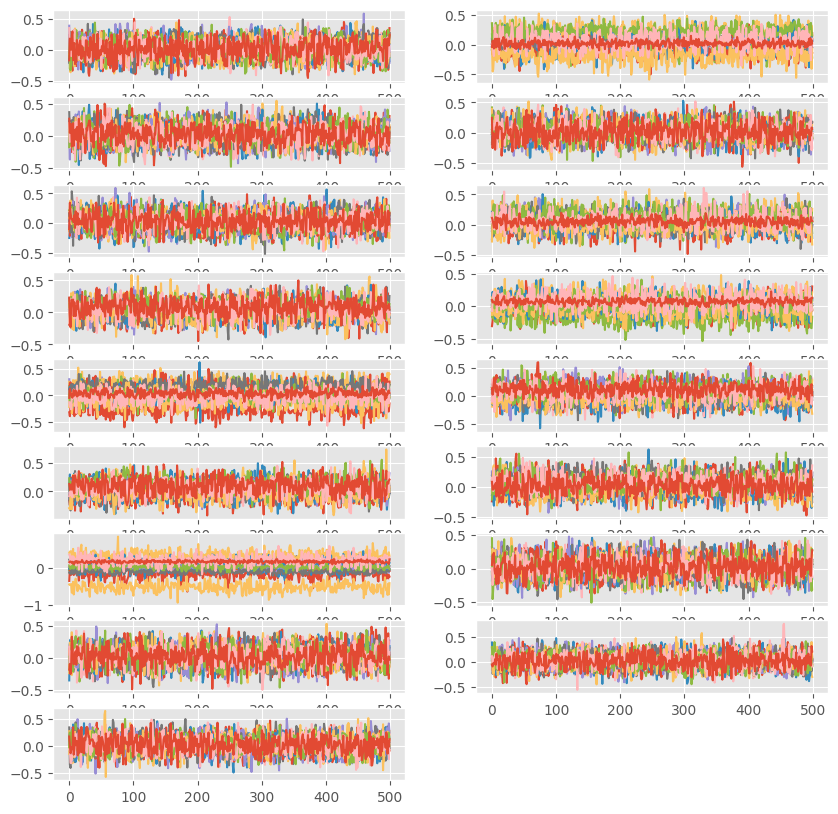

In [19]:
plt.rcParams['figure.figsize'] = (10, 10)

for i in range(17): #Looking at traceplot for beta parameters [Change the second index to switch between developed/developing]
    plt.subplot(9,2,i+1)
    plt.plot(posterior_samples_twoLevel_AB["beta"][::2,1,i,:])

#### Plotting traceplots for alpha

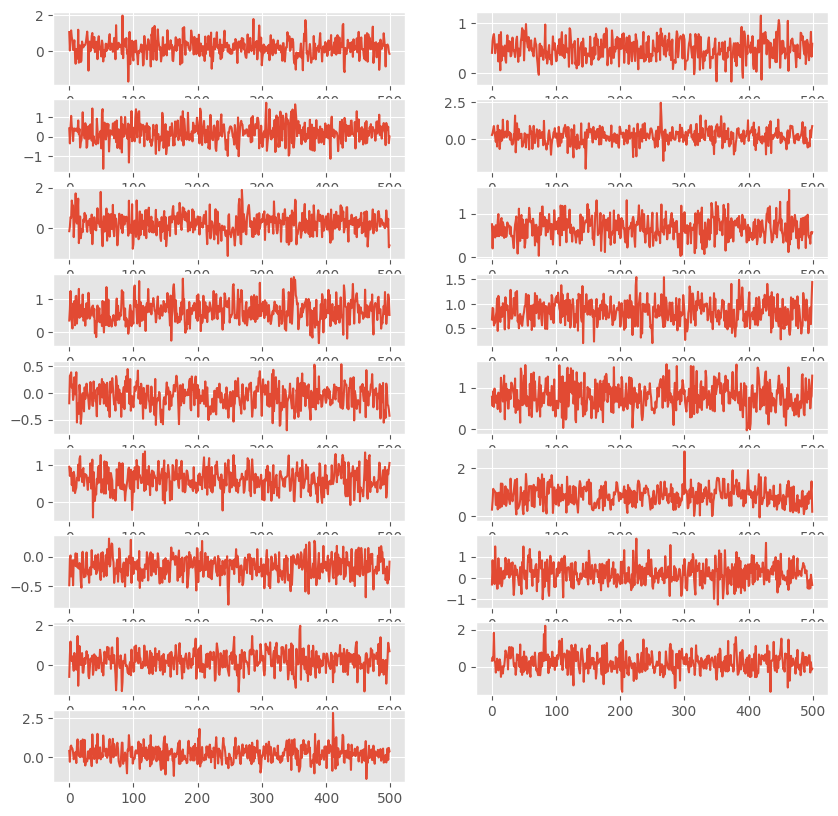

In [34]:
plt.rcParams['figure.figsize'] = (10, 10)

for i in range(17): #Looking at traceplot for alpha parameters [Change the second index to switch between developed/developing]
    plt.subplot(9,2,i+1)
    plt.plot(posterior_samples_twoLevel_AB["alpha"][::2,1,i])

#### Looking into the autocorrelation to validate thinning

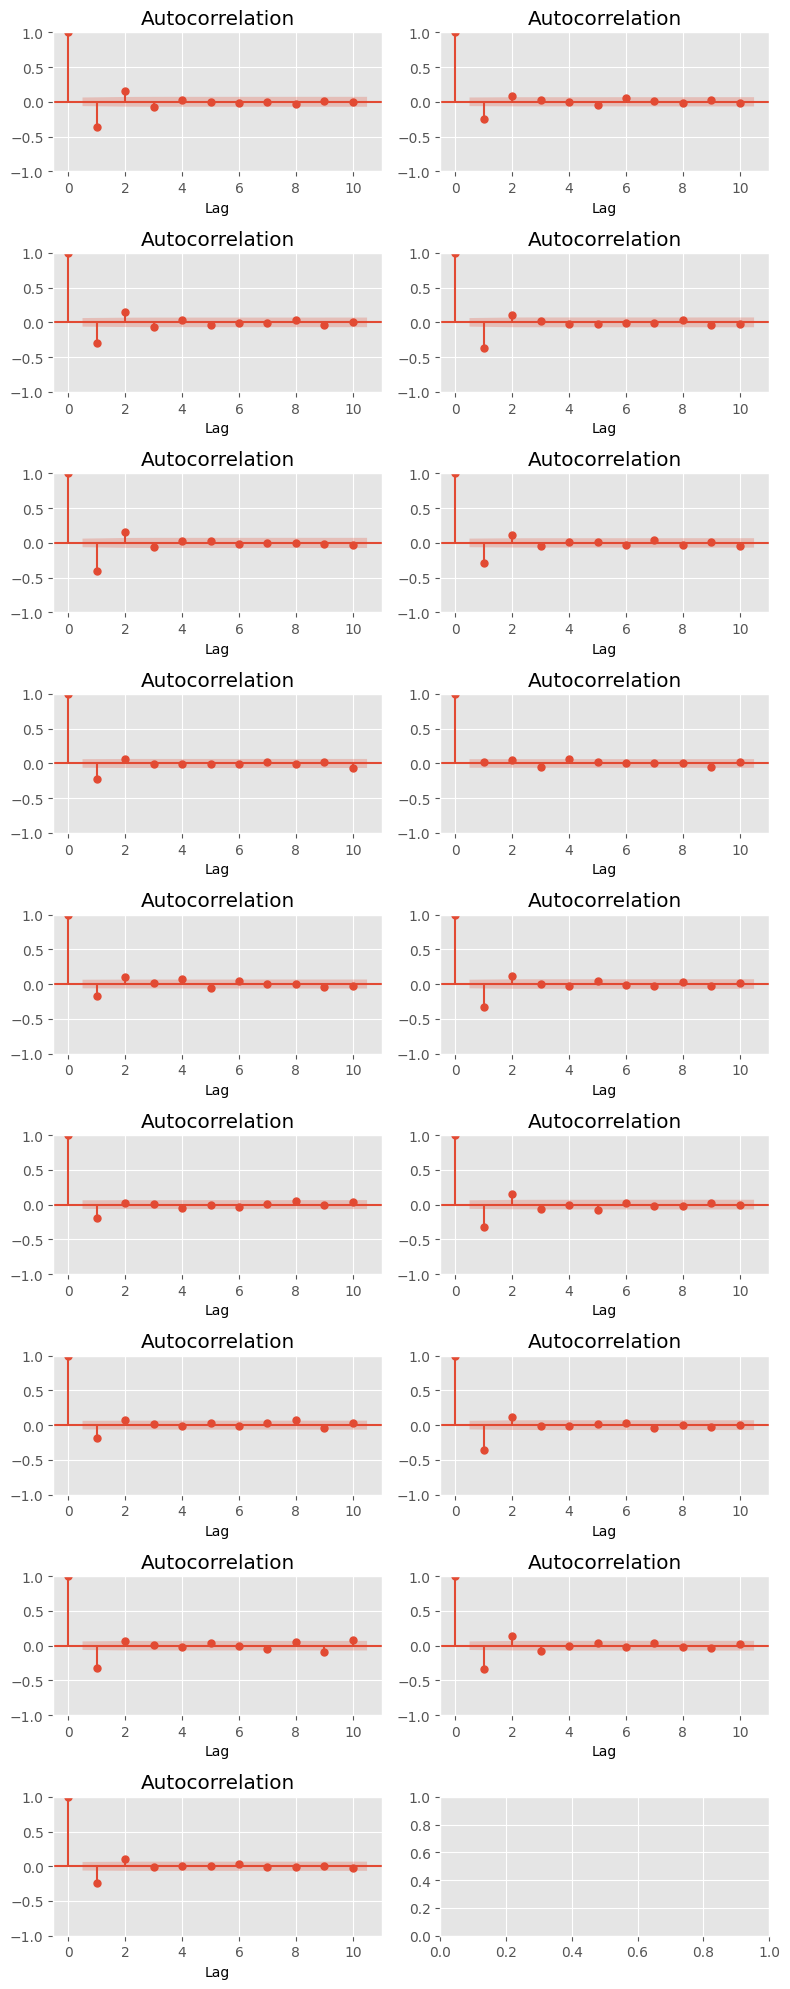

In [37]:
import statsmodels.api as sm

#Looking a autocorrelation without thinning
fig, axs = plt.subplots(9,2, figsize=(8, 20))

# Iterate over data and create ACF plots in subplots
for i in range(17):    
    row = i // 2; col = i % 2
    
    ax = axs[row, col]
    sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][:,1,i,1], ax=ax, lags=10) #Plot ACF
    ax.set_xlabel("Lag")

plt.tight_layout()

# Display the plot
plt.show()


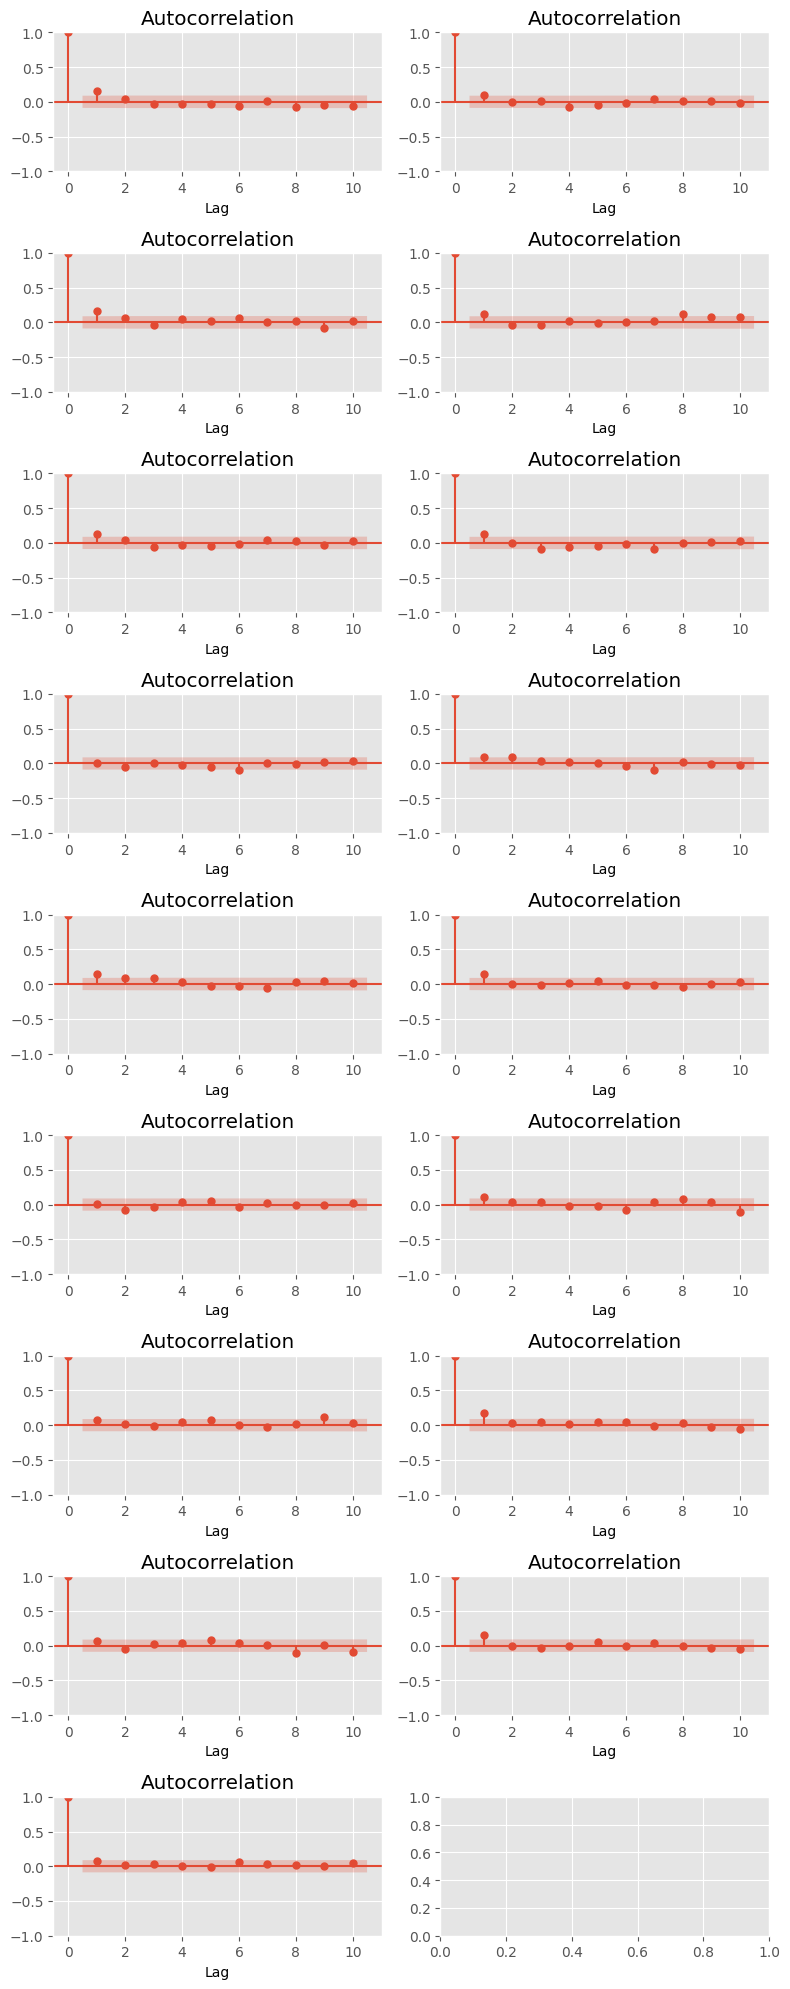

In [39]:
#Looking a autocorrelation with thinning
fig, axs = plt.subplots(9,2, figsize=(8, 20))

# Iterate over data and create ACF plots in subplots
for i in range(17):
    row = i // 2; col = i % 2
    
    ax = axs[row, col]
    sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][::2,1,i,1], ax=ax, lags=10) #Plot ACF
    ax.set_xlabel("Lag")

plt.tight_layout()

# Display the plot
plt.show()

C:\Users\Magnus\AppData\Local\Temp\ipykernel_720\2060158584.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


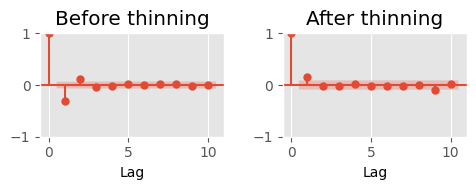

In [33]:
rand1 = random.randint(0, 1)
rand2 = random.randint(0, 16)
rand3 = random.randint(0, 14)

fig, axs = plt.subplots(1,2, figsize=(5, 2))

ax = axs[0]
sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][:,rand1,rand2,rand3], ax=ax, lags=10) #Plot ACF
ax.set_xlabel("Lag")
ax.set_title("Before thinning")

ax = axs[1]
sm.graphics.tsa.plot_acf(posterior_samples_twoLevel_AB["beta"][::2,rand1,rand2,rand3], ax=ax, lags=10) #Plot ACF
ax.set_xlabel("Lag")
ax.set_title("After thinning")

fig.tight_layout()
fig.show()

fig.savefig('ACF_plot.eps',format='eps',transparent=True)

In [21]:
#Calculating RMSE 
beta_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["beta"][::2], axis=0)
alpha_hat_TwoLevel_AB =torch.mean(posterior_samples_twoLevel_AB["alpha"][::2], axis=0)

def ErrorTestFun_Model4(X_values,cont_idx,dev_idx,y_values):
    multi_row = np.multiply(X_values,beta_hat_TwoLevel_AB[dev_idx,cont_idx,:])
    beta_part = torch.sum(multi_row,dim=1)

    y_hat = alpha_hat_TwoLevel_AB[dev_idx,cont_idx] + beta_part

    preds = y_hat.numpy() * y_std + y_mean
    y_true = y_values * y_std + y_mean

    rmse = np.sqrt(np.mean((preds - y_true)**2))
    
    return rmse
    
rmse_train = ErrorTestFun_Model4(X_train, subregion_train,developed_train_pyro, y_train)
rmse_test  = ErrorTestFun_Model4(X_test, subregion_test, developed_test_pyro, y_test)
rmse_val   = ErrorTestFun_Model4(X_val, subregion_val, developed_val_pyro,  y_val)

print("RMSE train: %.3f \nRMSE test: %.3f \nRMSE val: %.3f" % (rmse_train,rmse_test,rmse_val))

RMSE train: 1.887 
RMSE test: 2.361 
RMSE val: 2.293


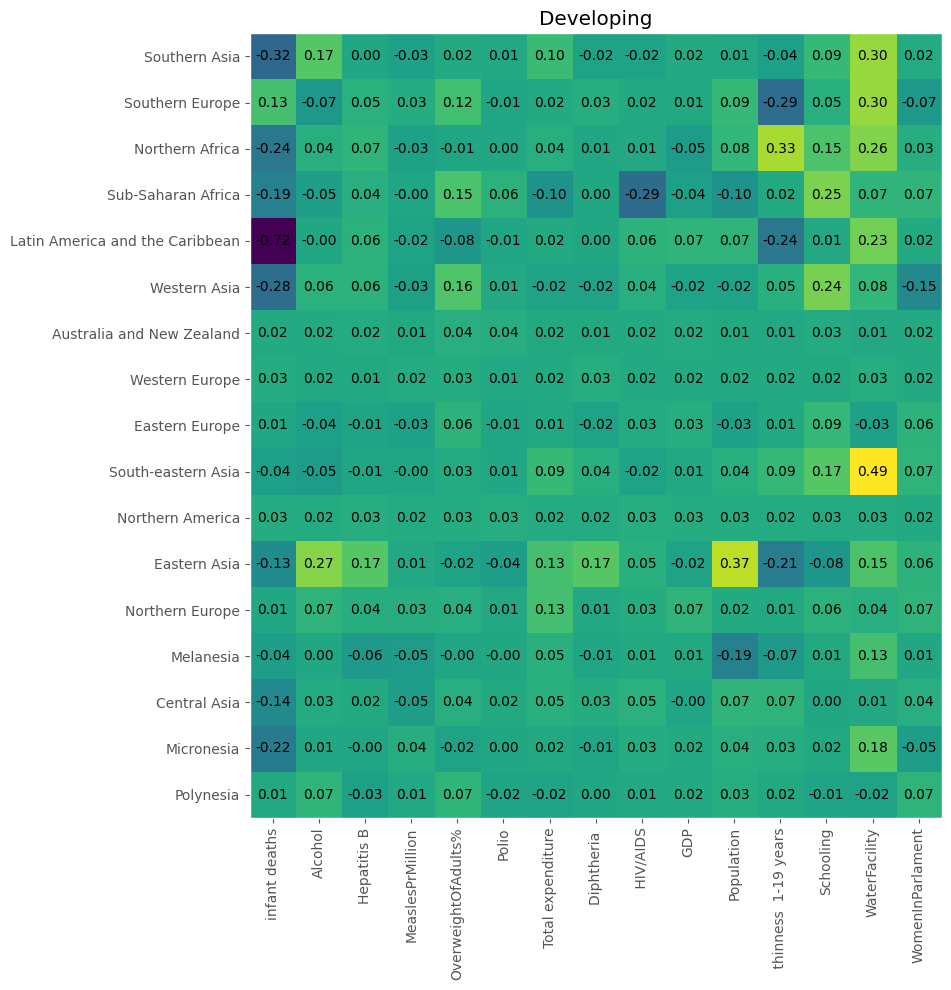

In [25]:
#Plotting Beta parameters for the Developing grouping 
list_labels = LED.columns.tolist()
num_betavalues = 15

heatMap_Beta_0 = beta_hat_TwoLevel_AB[0, :, :].numpy()

plt.imshow(heatMap_Beta_0,cmap='viridis') #Plot the values 
plt.grid(visible=False)
plt.xticks(range(num_betavalues), list_labels[6:], rotation=90)
plt.yticks(list(subregion_dict.values()),list(subregion_dict.keys()))
plt.title("Developing")

for i in range(heatMap_Beta_0.shape[0]): #Add the number in the heatmap
    for j in range(heatMap_Beta_0.shape[1]):
        plt.text(j, i, f'{heatMap_Beta_0[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig("BetaMatrixDev0.eps",format="eps")

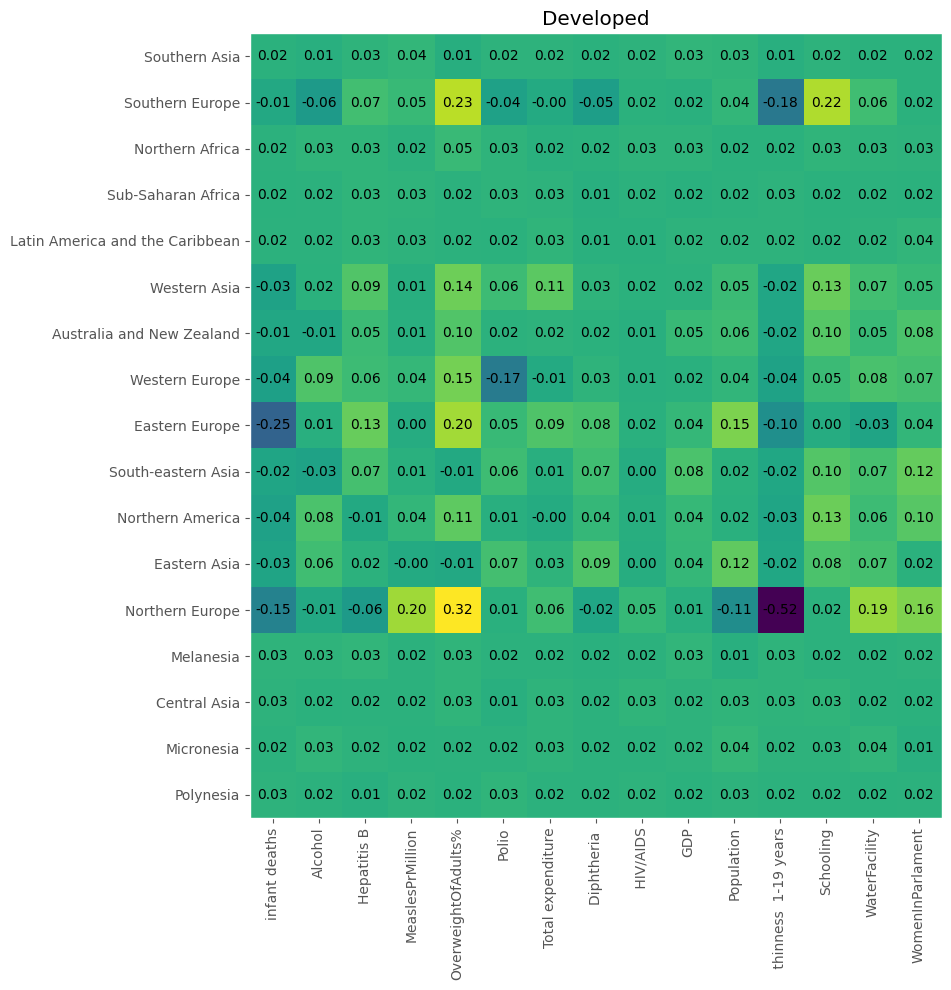

In [26]:
#Plotting Beta parameters for the Developed grouping 
heatMap_Beta_1 = beta_hat_TwoLevel_AB[1, :, :].numpy()

plt.imshow(heatMap_Beta_1,cmap='viridis') #Plot the values 
plt.grid(visible=False)
plt.xticks(range(num_betavalues), list_labels[6:], rotation=90)
plt.yticks(list(subregion_dict.values()),list(subregion_dict.keys()))
plt.title("Developed")

for i in range(heatMap_Beta_1.shape[0]): #Add the number in the heatmap
    for j in range(heatMap_Beta_1.shape[1]):
        plt.text(j, i, f'{heatMap_Beta_1[i, j]:.2f}', ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig("BetaMatrixDev1.eps",format="eps")

In [27]:
#Calculating to 90%CI for each of the alpha parameters
ci_lower_dev1 = np.array([])
ci_upper_dev1 = np.array([])

for i in range(17):
    ci_lower_dev1 = np.append(ci_lower_dev1, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,1,i], (100 - 90) / 2))
    ci_upper_dev1 = np.append(ci_upper_dev1, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,1,i], 100 - (100 - 90) / 2))
    
ci_lower_dev0 = np.array([])
ci_upper_dev0 = np.array([])

for i in range(17):
    ci_lower_dev0 = np.append(ci_lower_dev0, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,0,i], (100 - 90) / 2))
    ci_upper_dev0 = np.append(ci_upper_dev0, np.percentile(posterior_samples_twoLevel_AB["alpha"][::2,0,i], 100 - (100 - 90) / 2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


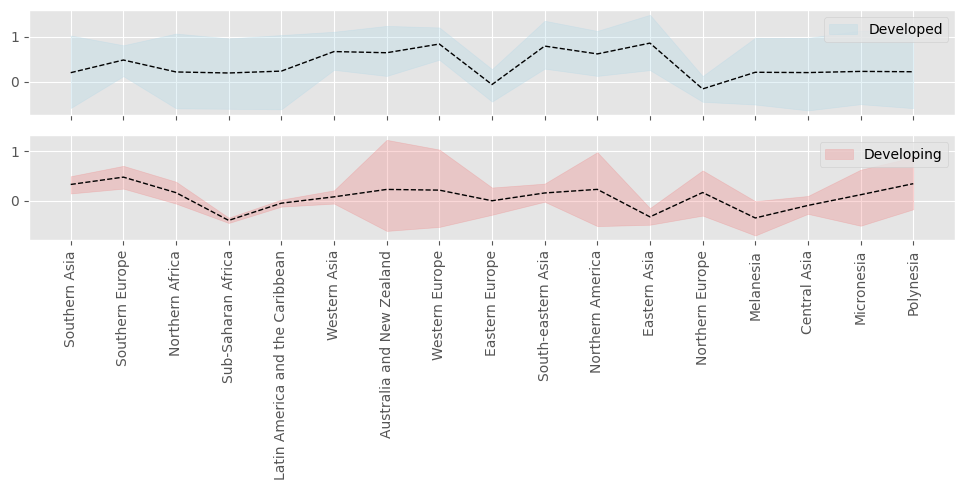

In [31]:
plt.figure(figsize=(10, 5))

plt.subplot(2,1,1)
plt.fill_between(list(subregion_dict.values()),ci_lower_dev1,ci_upper_dev1,alpha=0.3,label="Developed",color="lightblue")
plt.plot(alpha_hat_TwoLevel_AB[1, :],linestyle="--",color="black",linewidth=1.0)
plt.xticks(np.arange(17))
plt.tick_params(axis='x', labelbottom=False)
plt.legend()
plt.subplot(2,1,2)
plt.fill_between(list(subregion_dict.values()),ci_lower_dev0,ci_upper_dev0,alpha=0.3,label="Developing",color="lightcoral")
plt.plot(alpha_hat_TwoLevel_AB[0, :],linestyle="--",color="black",linewidth=1.0)
plt.xticks(list(subregion_dict.values()), list(subregion_dict.keys()))
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()

plt.savefig('alpha_par_res.eps',format='eps')
plt.show()